In [173]:
import pandas as pd
import json
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px

import requests

#%load_ext google.colab.data_table

plt.style.use('ggplot')


# HSBC

In [174]:
# Importing data from API, cleaning, flattening nested fields

response = json.loads(requests.get("https://api.hsbc.com/open-banking/v2.2/branches").text)
df = pd.json_normalize(
    response, 
    record_path =['data',['Brand']],
    errors='ignore',
    record_prefix='_'
)
df = pd.json_normalize(df['_Branch'][0])
df = df[['Name','Accessibility','PostalAddress.GeoLocation.GeographicCoordinates.Latitude','PostalAddress.GeoLocation.GeographicCoordinates.Longitude']]

# expand df.tags into its own dataframe
access = df['Accessibility'].apply(pd.Series)

# rename each variable is tags
access = access.rename(columns = lambda x : 'accessibility_' + str(x))

# concatenate newly named columns into df
df = pd.concat([df[:], access[:]], axis=1)


# Remove redundant column
df.drop(columns='Accessibility', axis=1, inplace=True)

df.replace(np.nan, 'None', inplace=True)

# Rename geo columns
df.rename(columns={'PostalAddress.GeoLocation.GeographicCoordinates.Latitude':'Latitude',
                   'PostalAddress.GeoLocation.GeographicCoordinates.Longitude':'Longitude'},
         inplace=True)

# Chage datatype for Lat/Lon

df[['Latitude','Longitude']] = df[['Latitude','Longitude']].astype(float)

def accessibility(row):
    if row['accessibility_0'] == 'WheelchairAccess' and row['accessibility_1'] == 'None':
        return 'Wheelchair Only'
    elif row['accessibility_0'] == 'None' and row['accessibility_1'] == 'AudioCashMachine':
        return 'Inloop Only'
    elif row['accessibility_0'] == 'None' and row['accessibility_1'] == 'None':
        return 'None'
    else:
        return 'Both'
# Apply the function  
df['Accessibility'] = df.apply(lambda row: accessibility(row), axis=1)


# Function to assign colours for markes on map:

def accessibility_colour(row):
    if row['accessibility_0'] == 'WheelchairAccess' and row['accessibility_1'] == 'None':
        return '#003FF6'
    elif row['accessibility_0'] == 'None' and row['accessibility_1'] == 'AudioCashMachine':
        return '#F4D03F'
    elif row['accessibility_0'] == 'None' and row['accessibility_1'] == 'None':
        return '#E74C3C'
    else:
        return '#27AE60'
# Apply the function  
df['colour'] = df.apply(lambda row: accessibility_colour(row), axis=1)

# Nation Wide

In [175]:
response = json.loads(requests.get('https://locations.nationwidebranches.co.uk/open-banking/v2.2/branches').text)

df_nw = pd.json_normalize(
    response, 
    record_path =['data',['Brand']],
    errors='ignore',
    record_prefix='_'
)

# Nation Wide 
df_nw = pd.json_normalize(df_nw['_Branch'][0])

df_nw = df_nw[['Name','Accessibility',
               'PostalAddress.GeoLocation.GeographicCoordinates.Latitude',
               'PostalAddress.GeoLocation.GeographicCoordinates.Longitude']]
df_nw.head()

access_nw = df_nw.Accessibility.apply(pd.Series)
access_nw = access_nw.rename(columns = lambda x : 'accessibility_' + str(x))

df_nw = pd.concat([df_nw[:], access_nw[:]], axis=1)

df_nw['accessibility_w'] = df_nw.accessibility_0[(df_nw.accessibility_0 == 'WheelchairAccess')]
df_nw.accessibility_w.fillna(df_nw.accessibility_1[df_nw.accessibility_1.str.contains('Wheelchair', na=True)], inplace=True)
df_nw['accessibility_h'] = df_nw.accessibility_0[(df_nw.accessibility_0 == 'InductionLoop') | (df_nw.accessibility_1 == 'InductionLoop')]

df_nw.drop(columns=['Accessibility','accessibility_0', 'accessibility_1'], inplace=True)

df_nw.replace(np.nan, 'None', inplace=True)

df_nw.rename(columns={'PostalAddress.GeoLocation.GeographicCoordinates.Latitude':'Latitude',
                   'PostalAddress.GeoLocation.GeographicCoordinates.Longitude':'Longitude'},
         inplace=True)

df_nw[['Latitude','Longitude']] = df_nw[['Latitude','Longitude']].astype(float)

def accessibility_2(row):
    if row['accessibility_w'] == 'WheelchairAccess' and row['accessibility_h'] == 'None':
        return 'Wheelchair Only'
    elif row['accessibility_w'] == 'None' and row['accessibility_h'] == 'InductionLoop':
        return 'InductionLoop Only'
    elif row['accessibility_w'] == 'None' and row['accessibility_h'] == 'None':
        return 'None'
    else:
        return 'Both'
# Apply the function  
df_nw['Accessibility'] = df_nw.apply(lambda row: accessibility_2(row), axis=1)


def accessibility_colour_2(row):
    if row['accessibility_w'] == 'WheelchairAccess' and row['accessibility_h'] == 'None':
        return '#003FF6'
    elif row['accessibility_w'] == 'None' and row['accessibility_h'] == 'InductionLoop':
        return '#FA8406'
    elif row['accessibility_w'] == 'None' and row['accessibility_h'] == 'None':
        return '#E74C3C'
    else:
        return '#27AE60'
# Apply the function  
df_nw['colour'] = df_nw.apply(lambda row: accessibility_colour_2(row), axis=1)

In [176]:
df_nw


,Name,Latitude,Longitude,accessibility_w,accessibility_h,Accessibility,colour
0,London 1284,51.513282,-0.077072,WheelchairAccess,InductionLoop,Both,#27AE60
1,Whittlesey 1436,52.556636,-0.127013,WheelchairAccess,InductionLoop,Both,#27AE60
2,Harrogate 0818,53.993116,-1.542411,WheelchairAccess,InductionLoop,Both,#27AE60
3,Birmingham 0517,52.416515,-1.969492,WheelchairAccess,InductionLoop,Both,#27AE60
4,Rotherham 0835,53.431615,-1.355864,WheelchairAccess,None,Wheelchair Only,#003FF6
...,...,...,...,...,...,...,...
641,Derby 1270,52.906799,-1.381043,WheelchairAccess,InductionLoop,Both,#27AE60
642,Wandsworth 0998,51.454743,-0.193333,WheelchairAccess,None,Wheelchair Only,#003FF6
643,Brierley Hill 0790,52.482825,-2.112729,WheelchairAccess,InductionLoop,Both,#27AE60
644,Barnstaple 0465,51.081865,-4.060041,None,InductionLoop,InductionLoop Only,#FA8406


# Mapping

In [177]:
mapbox_token = 'pk.eyJ1IjoidG9tejg0IiwiYSI6ImNrOWdzeDl2bzBuenozbHRieXp4dmo2cmUifQ.8QfuEG6pmLxa-zdroSpbrw'
px.set_mapbox_access_token(mapbox_token)

fig = px.scatter_mapbox(df, lat="Latitude", lon="Longitude",
                        size_max=15, zoom=5,
                       text=df.Name)
fig.update_traces(marker=dict(size=8,
                              color=df.colour))
fig.update_layout(mapbox_style='open-street-map')
fig.show()

In [178]:
df.head()

,Name,Latitude,Longitude,accessibility_0,accessibility_1,Accessibility,colour
0,Beeston,52.926777,-1.215878,WheelchairAccess,AudioCashMachine,Both,#27AE60
1,"Eastwood, Nottinghamshire",53.018185,-1.305781,WheelchairAccess,AudioCashMachine,Both,#27AE60
2,Ilkeston,52.973766,-1.309159,WheelchairAccess,AudioCashMachine,Both,#27AE60
3,Long Eaton,52.898041,-1.271489,None,None,None,#E74C3C
4,"Ashford, Kent",51.148852,0.873529,WheelchairAccess,AudioCashMachine,Both,#27AE60


In [179]:
df.columns

Index(['Name', 'Latitude', 'Longitude', 'accessibility_0', 'accessibility_1',
       'Accessibility', 'colour'],
      dtype='object')

In [180]:
fig = px.scatter_mapbox(df_nw, lat="Latitude", lon="Longitude",
                        size_max=15, zoom=5,
                       text=df_nw.Name)
fig.update_traces(marker=dict(size=8,
                              color=df_nw.colour))
fig.update_layout(mapbox_style='open-street-map')
fig.show()

<AxesSubplot:>

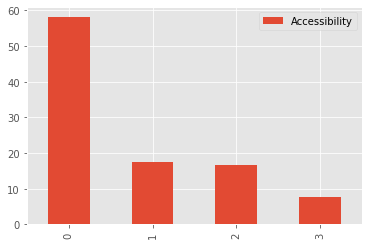

In [181]:
(pd.DataFrame(df_nw.Accessibility.value_counts(normalize=True).mul(100).round(2)).reset_index()
 .plot(kind='bar'))


In [ ]:
hsbc_pct = pd.DataFrame(df_nw.Accessibility.value_counts(normalize=True).mul(100).round(1)).reset_index()
hsbc_pct.rename(columns= {'index':'type'}, inplace=True)
nw_pct

In [182]:
nw_pct = pd.DataFrame(df_nw.Accessibility.value_counts(normalize=True).mul(100).round(1)).reset_index()
nw_pct.rename(columns= {'index':'type'}, inplace=True)
nw_pct

,type,Accessibility
0,Both,58.0
1,Wheelchair Only,17.5
2,InductionLoop Only,16.7
3,None,7.7


In [189]:
fig_pct_nw = px.bar(nw_pct, x='type', y='Accessibility',
                   text='Accessibility')
fig_pct_nw.update_traces(marker_color='#F17D0F',
                        marker_line_color='#F7DC6F',
                        marker_line_width=2,
                        opacity=0.8)
fig_pct_nw.update_layout(title_text='Percentage of Nation Wide Branches by Accessibility Type')
fig_pct_nw.show()